In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 70
plt.rcParams['figure.figsize'] = [10, 5]
from pathlib import Path
from tqdm.notebook import tqdm

from parsing.zero_coupon import ZeroCoupon
import statsmodels.api as sm

In [14]:
_imoex_path = Path('..', 'data', 'index', 'history', 'IMOEX.csv')
_rtsi_path = Path('..', 'data', 'index', 'history', 'RTSI.csv')
_CB_rate_path = Path('..', 'data', 'credit_rate.csv')
_indicative_rate_path = Path('..', 'data', 'RUB_ind.csv')
_deposits_path = Path('..', 'data', 'deposits', 'RUB.pickle')
_CNY_Path = Path('..', 'data', 'currencies', 'history', 'CNYRUB_TOM.csv')
_USD_Path = Path('..', 'data', 'currencies', 'history', 'USD000UTSTOM.csv')

In [15]:
imoexDF = pd.read_csv(_imoex_path, index_col="TRADEDATE", usecols=["TRADEDATE", "CLOSE"])
imoexDF.index = pd.to_datetime(imoexDF.index)

rtsi_DF = pd.read_csv(_rtsi_path, usecols=["TRADEDATE", "CLOSE"])
rtsi_DF.TRADEDATE = pd.to_datetime(rtsi_DF.TRADEDATE).apply(lambda x: x.date())
rtsi_DF.set_index("TRADEDATE", inplace=True)
rtsi_USD_df = rtsi_DF.copy()

RUB_ind_rate = pd.read_csv(_indicative_rate_path).drop("#", axis=1)
RUB_ind_rate.moment = pd.to_datetime(RUB_ind_rate.moment).apply(lambda x: x.date())
RUB_ind_rate.set_index("moment", inplace=True)

rtsi_DF = rtsi_DF.mul(RUB_ind_rate, fill_value=1)
rtsi_DF["CLOSE"] = rtsi_DF["CLOSE"] * rtsi_DF["value"]
rtsi_DF.drop("value", inplace=True, axis=1)
rtsi_DF = rtsi_DF[~rtsi_DF.index.duplicated(keep='last')]
rtsi_DF.index = pd.to_datetime(rtsi_DF.index)

#CB_rate_df = pd.read_csv(_CB_rate_path, sep="\t", names=["date", "rate"])
#CB_rate_df.rate = CB_rate_df.rate.str.replace(",", ".").astype(float)
#CB_rate_df.set_index("date", inplace=True)
#CB_rate_df.index = pd.to_datetime(CB_rate_df.index)
#idx = pd.date_range("01-01-2016", "31-12-2021")
#CB_rate_df = CB_rate_df.reindex(idx).fillna(method="ffill")

CNY_df = pd.read_csv(_CNY_Path, usecols=["TRADEDATE", "CLOSE"])
CNY_df.TRADEDATE = pd.to_datetime(CNY_df.TRADEDATE).apply(lambda x: x.date())
CNY_df.set_index("TRADEDATE", inplace=True)


rtsi_DF.CLOSE = rtsi_DF.CLOSE.fillna(method="ffill")
CNY_df.CLOSE = CNY_df.fillna(method="ffill")
CNY_df.loc[pd.to_datetime("2019-05-03").date()] = CNY_df.loc[pd.to_datetime("2019-05-02").date()]

USD_df = pd.read_csv(_USD_Path, usecols=["TRADEDATE", "CLOSE"])
USD_df.TRADEDATE = pd.to_datetime(USD_df.TRADEDATE).apply(lambda x: x.date())
USD_df.set_index("TRADEDATE", inplace=True)

zeroCoupon = ZeroCoupon().returns()["rate_1.0"].to_frame()["rate_1.0"]
zeroCoupon = zeroCoupon.reindex(rtsi_DF.index).interpolate().to_frame().iloc[1:]

In [16]:
data = pd.DataFrame({'RTSI_RUB': rtsi_DF.pct_change().CLOSE.iloc[1:],
                     'RTSI_USD': rtsi_USD_df.pct_change().CLOSE.iloc[1:],
                     'IMOEX': imoexDF.pct_change().CLOSE.iloc[1:],
                     'CNY': CNY_df.pct_change().CLOSE.iloc[1:],
                     'USD': USD_df.pct_change().CLOSE.iloc[1:],
                     'ZeroCoupon': zeroCoupon["rate_1.0"]})

## SARIMAX

In [39]:
# На основании ACF/PACF
params = {'RTSI_RUB': {'p': 6,
                       'd': 0,
                       'q': 6,
                       'freq': 0,
                       'P': 0,
                       'D': 0,
                       'Q': 0},
          'RTSI_USD': {'p': 7,
                       'd': 0,
                       'q': 7,
                       'freq': 0,
                       'P': 0,
                       'D': 0,
                       'Q': 0},
          'IMOEX': {'p': 4,
                    'd': 0,
                    'q': 4,
                    'freq': 0,
                    'P': 0,
                    'D': 0,
                    'Q': 0},
          'CNY': {'p': 8,
                  'd': 0,
                  'q': 8,
                  'freq': 0,
                  'P': 0,
                  'D': 0,
                  'Q': 0},
          'USD': {'p': 8,
                  'd': 0,
                  'q': 8,
                  'freq': 0,
                  'P': 0,
                  'D': 0,
                  'Q': 0},
          'ZeroCoupon': {'p': 1,
                         'd': 0,
                         'q': 1,
                         'freq': 0,
                         'P': 0,
                         'D': 0,
                         'Q': 0}}

test_size = 0.1
train_len = int(data.shape[0] * (1 - test_size))

models = {}

data = data.resample("D").last()

for factor in tqdm(list(data)):
    for param, val in params[factor].items():
        locals()[param] = val

    model = sm.tsa.statespace.SARIMAX(data[factor].iloc[:train_len], order=(p, d, q),
                                      seasonal_order=(P, D, Q, freq), freq='D')

    model = model.fit(method='bfgs')
    models[factor] = model

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


         Current function value: -1.998743
         Iterations: 26
         Function evaluations: 104
         Gradient evaluations: 93


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: -1.857018
         Iterations: 37
         Function evaluations: 100
         Gradient evaluations: 89


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: -2.141309
         Iterations: 4
         Function evaluations: 75
         Gradient evaluations: 63


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: -2.295877
         Iterations: 11
         Function evaluations: 70
         Gradient evaluations: 60


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: -2.292650
         Iterations: 23
         Function evaluations: 94
         Gradient evaluations: 83


/Users/user/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: -2.814104
         Iterations: 16
         Function evaluations: 22
         Gradient evaluations: 22


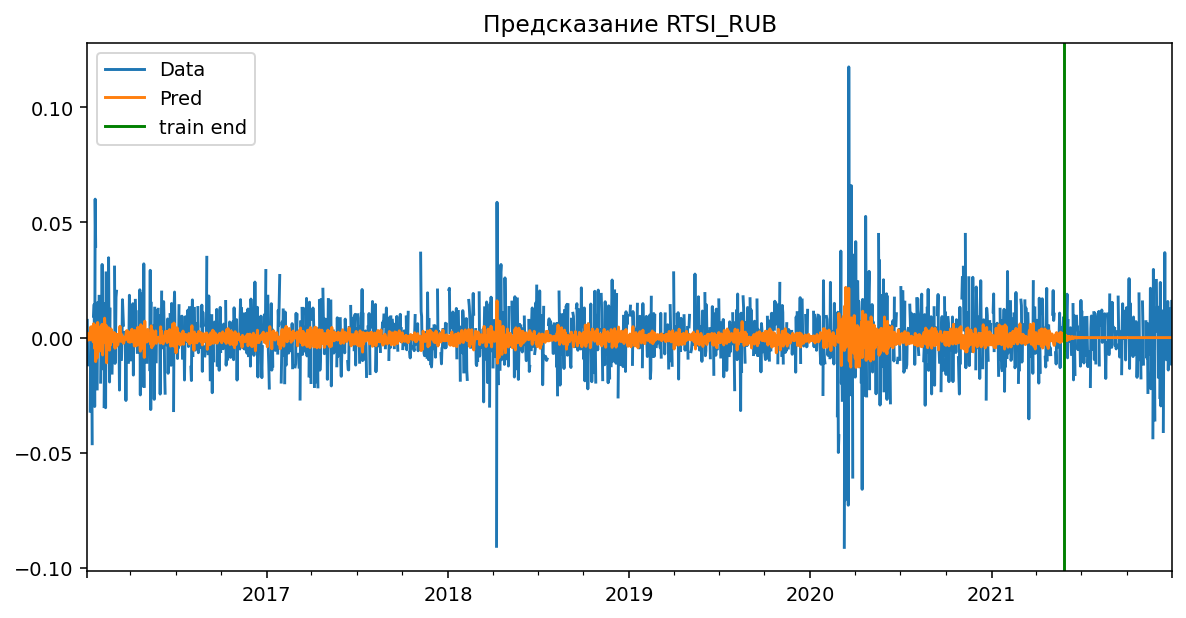

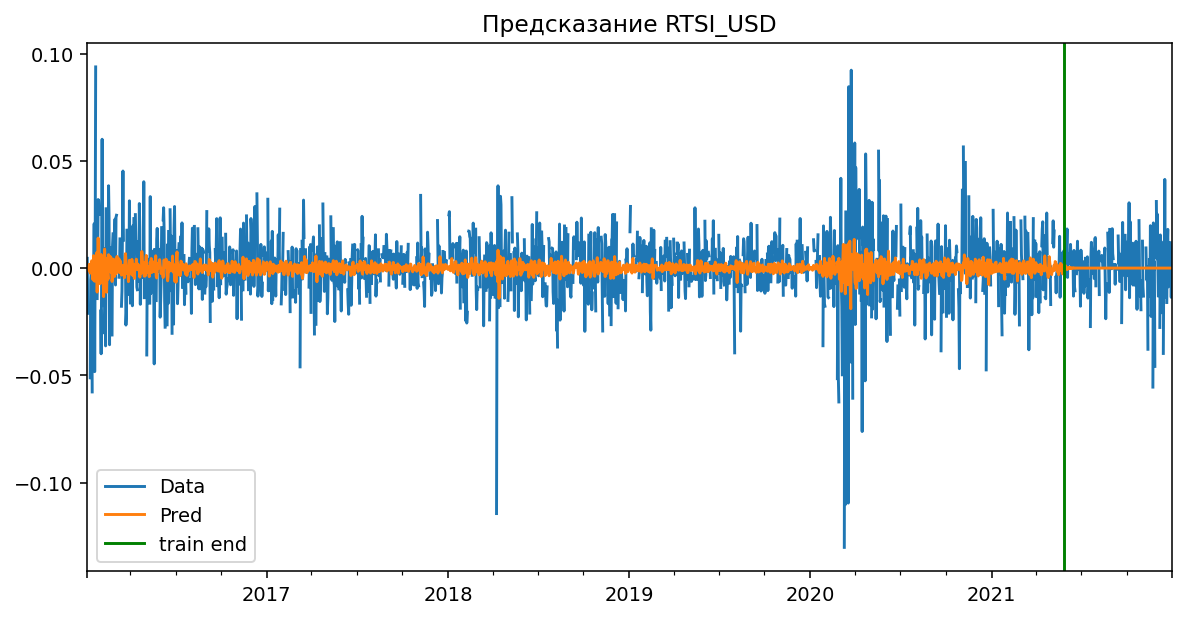

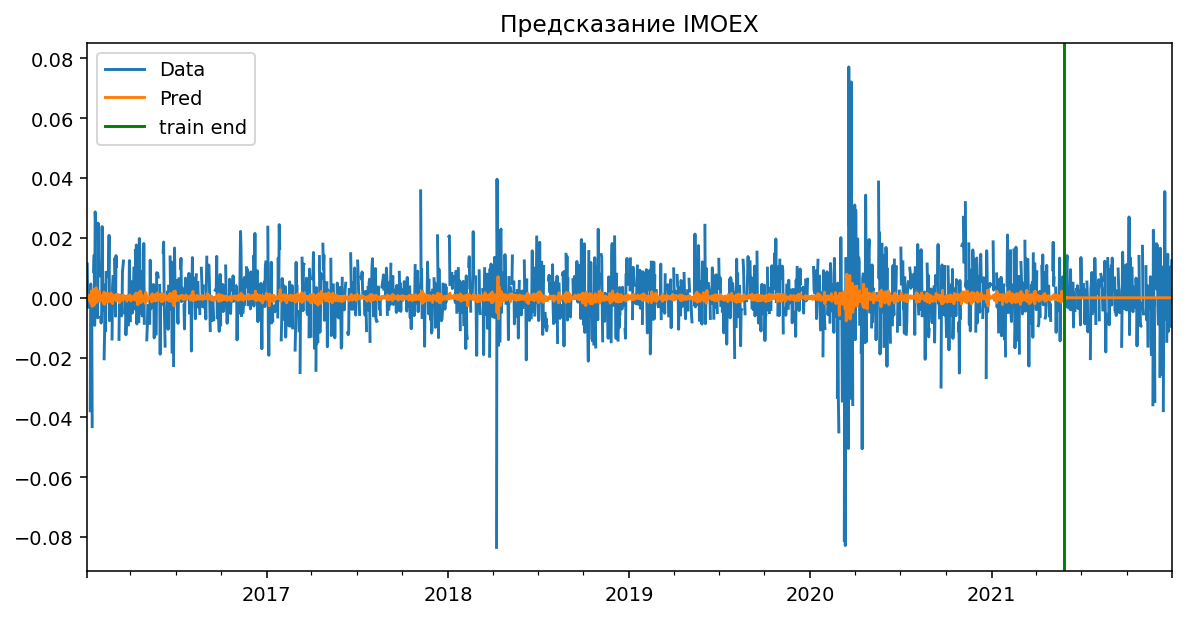

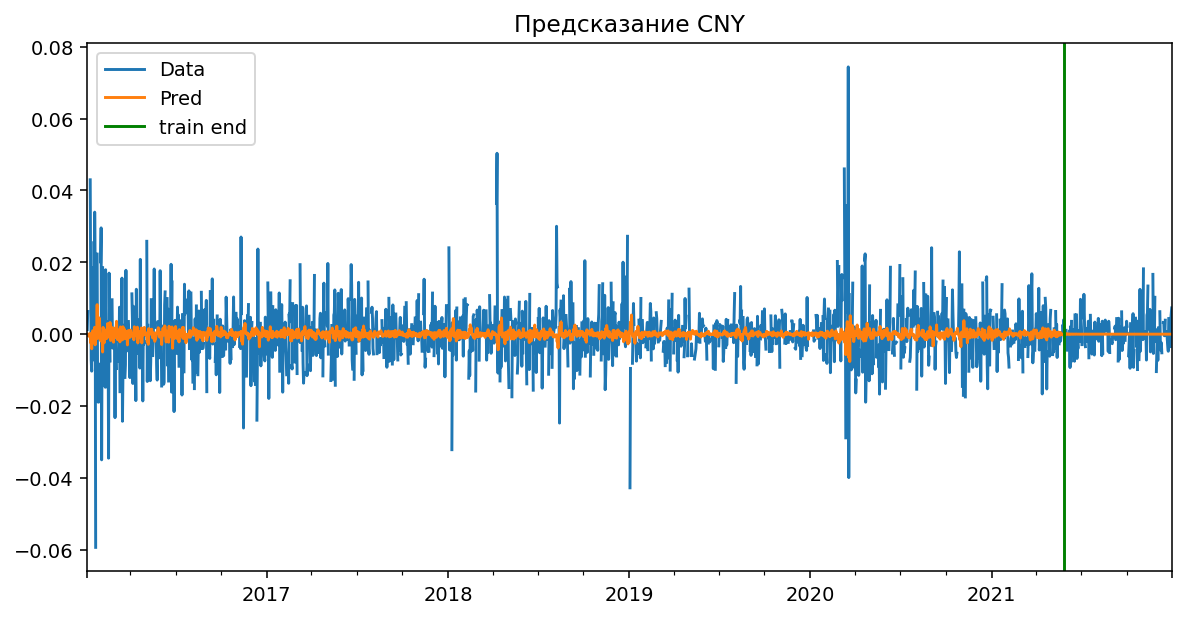

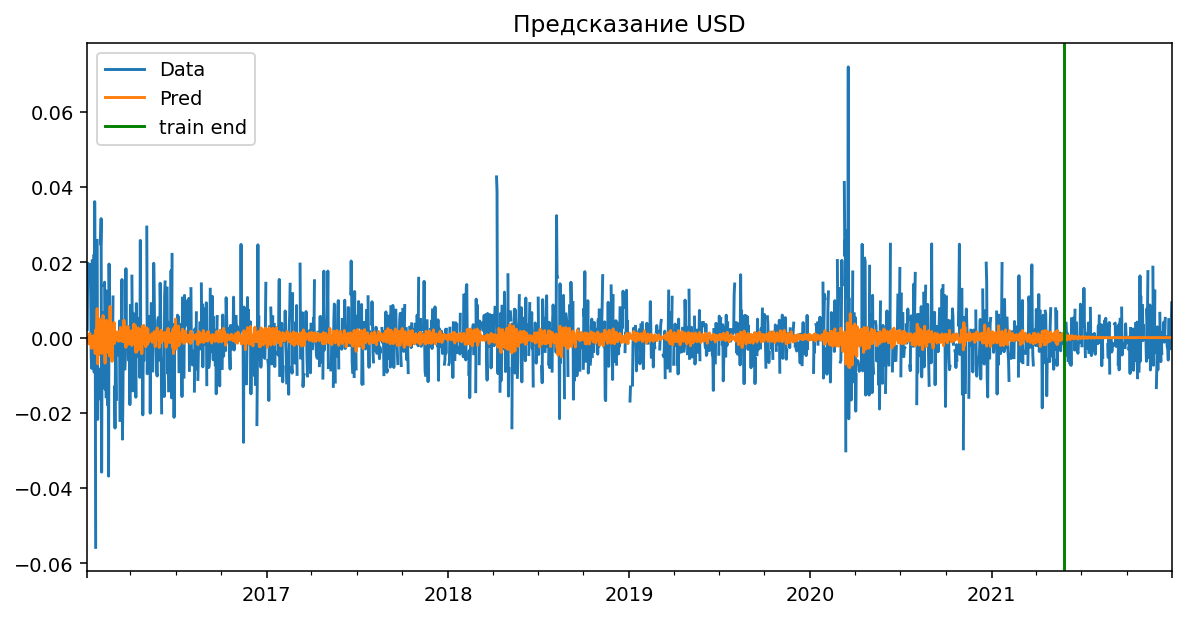

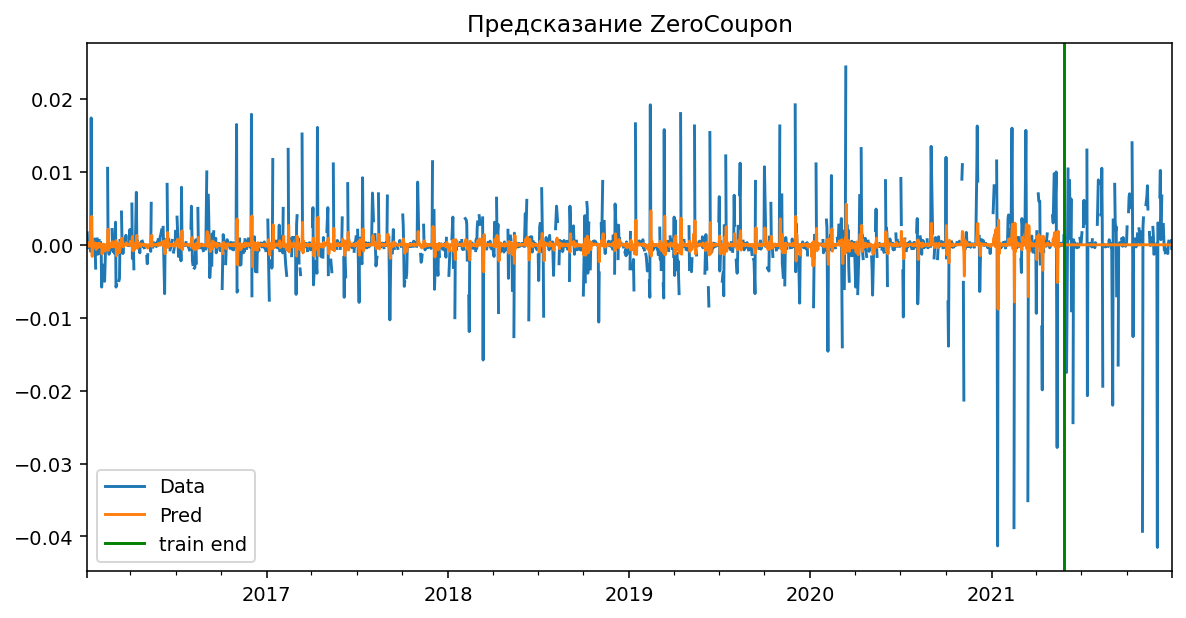

In [44]:
for factor, model in models.items():
    data[factor].plot(label='Data')
    model.predict(0, data.shape[0]).plot(label='Pred')
    plt.title(f'Предсказание {factor}')
    plt.axvline(data.index[train_len], label='train end', color='green')
    plt.legend();
    plt.show()